# Network Traffic Anomaly Detection with RaNN+LSTM

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input, Concatenate
import glob

In [3]:
class RandomizedNeuralNetwork(tf.keras.layers.Layer):
    def __init__(self, hidden_layers_sizes=[256, 128], activation='relu', **kwargs):
        super(RandomizedNeuralNetwork, self).__init__(**kwargs)
        self.hidden_layers_sizes = hidden_layers_sizes
        self.activation = activation
        self.random_layers = []
        
    def build(self, input_shape):
        # Get the feature dimension (last dimension)
        input_dim = input_shape[-1]
        
        # Create random hidden layers
        for units in self.hidden_layers_sizes:
            # Create fixed random weights
            w_init = np.random.normal(0, 1/np.sqrt(input_dim), (input_dim, units))
            b_init = np.random.normal(0, 1/np.sqrt(input_dim), (units,))
            
            # Convert to non-trainable tensorflow variables
            w = tf.Variable(w_init, trainable=False, dtype=tf.float32)
            b = tf.Variable(b_init, trainable=False, dtype=tf.float32)
            
            self.random_layers.append((w, b))
            input_dim = units

    def call(self, inputs):
        # Reshape input to 2D if it's 3D (batch_size, timesteps, features)
        if len(inputs.shape) == 3:
            batch_size, timesteps, features = tf.shape(inputs)[0], tf.shape(inputs)[1], tf.shape(inputs)[2]
            x = tf.reshape(inputs, [-1, features])
        else:
            x = inputs

        # Pass through each random layer
        for w, b in self.random_layers:
            x = tf.matmul(x, w) + b
            if self.activation == 'relu':
                x = tf.nn.relu(x)
            elif self.activation == 'tanh':
                x = tf.nn.tanh(x)

        # Reshape back to 3D if input was 3D
        if len(inputs.shape) == 3:
            x = tf.reshape(x, [batch_size, timesteps, self.hidden_layers_sizes[-1]])
        
        return x

def build_hybrid_rnn_lstm_model(input_shape, rnn_sizes=[256, 128], lstm_sizes=[128, 64]):
    """
    Build a hybrid model that combines RNN and LSTM with matching dimensions
    """
    # Input layer
    inputs = Input(shape=input_shape)
    
    # RNN path
    rnn = RandomizedNeuralNetwork(hidden_layers_sizes=rnn_sizes)(inputs)
    rnn = Dropout(0.3)(rnn)
    # Add a final LSTM to match dimensions with LSTM path
    rnn = LSTM(lstm_sizes[-1])(rnn)
    rnn = Dropout(0.3)(rnn)
    
    # LSTM path
    lstm = LSTM(lstm_sizes[0], return_sequences=True)(inputs)
    lstm = Dropout(0.3)(lstm)
    lstm = LSTM(lstm_sizes[1])(lstm)
    lstm = Dropout(0.3)(lstm)
    
    # Now both rnn and lstm have shape (batch_size, lstm_sizes[-1])
    combined = Concatenate()([rnn, lstm])
    
    # Final dense layers
    x = Dense(64, activation='relu')(combined)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    # Create model
    model = Model(inputs=inputs, outputs=outputs)
    
    # Compile
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

Current working directory: /home/sandeep/Capstone/ML_Model_Latest
Loading and preprocessing data...
Found 8 files
Processing ./data/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv...
Processing ./data/Friday-WorkingHours-Morning.pcap_ISCX.csv...
Building and training hybrid RNN-LSTM model...


2025-03-05 19:35:18.921499: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1, 78)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ randomized_neural_… │ (None, 1, 128)    │          0 │ input_layer[0][0] │
│ (RandomizedNeuralN… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 1, 128)    │    105,984 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1, 128)    │          0 │ randomized_neura… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 1, 128)    │          0 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 64)        │     49,408 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 64)        │     49,408 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ dropout_1[0][0],  │
│ (Concatenate)       │                   │            │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      8,256 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         65 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 213,121 (832.50 KB)

 Trainable params: 213,121 (832.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


2025-03-05 19:35:19.460020: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 72154368 exceeds 10% of free system memory.


3614/3614 ━━━━━━━━━━━━━━━━━━━━ 40s 9ms/step - accuracy: 0.9898 - loss: 0.0464 - val_accuracy: 0.9932 - val_loss: 0.0185
Epoch 2/10
3614/3614 ━━━━━━━━━━━━━━━━━━━━ 33s 9ms/step - accuracy: 0.9928 - loss: 0.0190 - val_accuracy: 0.9932 - val_loss: 0.0175
Epoch 3/10
3614/3614 ━━━━━━━━━━━━━━━━━━━━ 33s 9ms/step - accuracy: 0.9937 - loss: 0.0171 - val_accuracy: 0.9937 - val_loss: 0.0158
Epoch 4/10
3614/3614 ━━━━━━━━━━━━━━━━━━━━ 33s 9ms/step - accuracy: 0.9936 - loss: 0.0166 - val_accuracy: 0.9939 - val_loss: 0.0151
Epoch 5/10
3614/3614 ━━━━━━━━━━━━━━━━━━━━ 34s 9ms/step - accuracy: 0.9941 - loss: 0.0157 - val_accuracy: 0.9938 - val_loss: 0.0150
Epoch 6/10
3614/3614 ━━━━━━━━━━━━━━━━━━━━ 33s 9ms/step - accuracy: 0.9939 - loss: 0.0163 - val_accuracy: 0.9937 - val_loss: 0.0147
Epoch 7/10
3614/3614 ━━━━━━━━━━━━━━━━━━━━ 34s 9ms/step - accuracy: 0.9942 - loss: 0.0151 - val_accuracy: 0.9939 - val_loss: 0.0144
Epoch 8/10
3614/3614 ━━━━━━━━━━━━━━━━━━━━ 34s 9ms/step - accuracy: 0.9945 - loss: 0.0149 - val

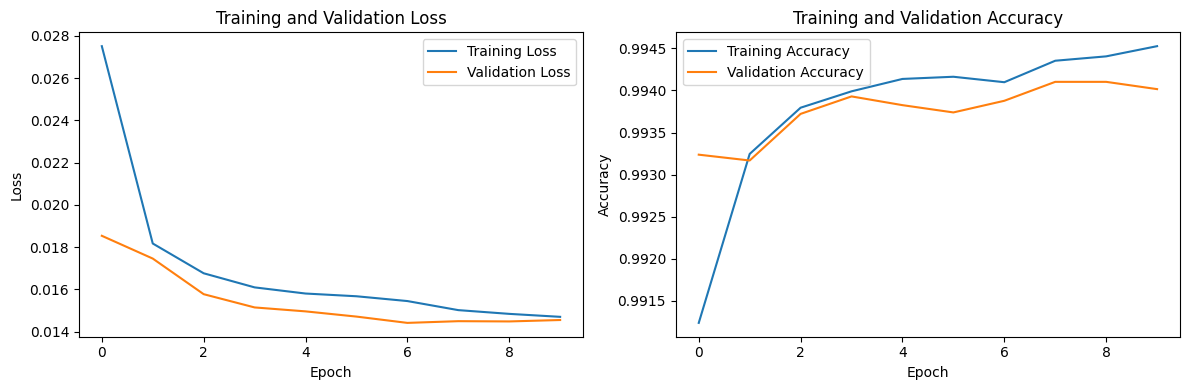

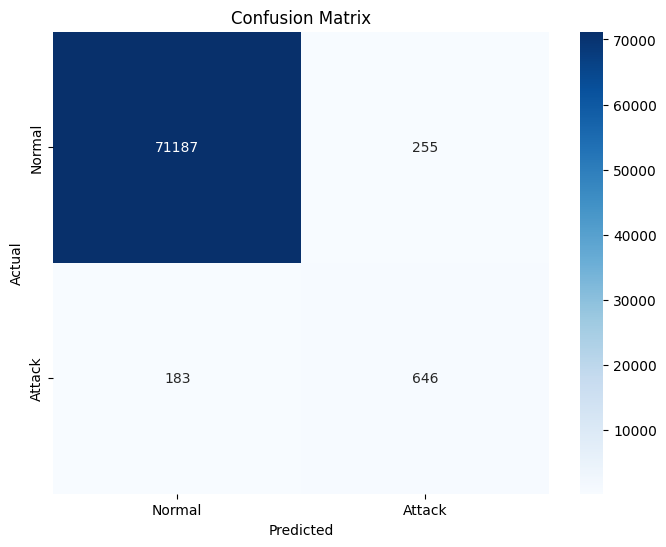

In [4]:
def main():
    print("Current working directory:", os.getcwd())

    # Data loading and preprocessing (keeping your existing code)
    print("Loading and preprocessing data...")
    data_dir = './data'
    all_files = glob.glob(os.path.join(data_dir, '*.pcap_ISCX.csv'))
    
    if not all_files:
        print("Checking subdirectories...")
        all_files = glob.glob(os.path.join(data_dir, '**/*.pcap_ISCX'), recursive=True)
    
    print(f"Found {len(all_files)} files")
    
    # Load and process files (same as your code)
    dfs = []
    files_to_process = all_files[:2]
    
    for file in files_to_process:
        print(f"Processing {file}...")
        try:
            df = pd.read_csv(file)
            df = df.dropna()
            numeric_cols = df.select_dtypes(include=[np.number]).columns
            if len(numeric_cols) > 0:
                df[numeric_cols] = df[numeric_cols].replace([np.inf, -np.inf], np.nan)
                df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].max() * 1000)
            dfs.append(df)
        except Exception as e:
            print(f"Error processing {file}: {e}")
    
    if not dfs:
        print("No data was loaded. Please check your files.")
        return
    
    full_df = pd.concat(dfs, ignore_index=True)
    
    # Prepare features and labels (same as your code)
    if 'Label' in full_df.columns:
        full_df.rename(columns={'Label': 'label'}, inplace=True)
    elif 'label' not in full_df.columns and ' Label' in full_df.columns:
        full_df.rename(columns={' Label': 'label'}, inplace=True)
    
    label_col = full_df.pop('label')
    full_df['label'] = label_col
    full_df['label'] = full_df['label'].apply(lambda x: 0 if x == 'BENIGN' else 1)
    
    numeric_cols = full_df.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols.remove('label')
    
    X = full_df[numeric_cols]
    y = full_df['label']
    
    # Split and scale data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    # Reshape data for LSTM
    X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
    X_val_reshaped = X_val_scaled.reshape(X_val_scaled.shape[0], 1, X_val_scaled.shape[1])
    X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])
    
    # Build and train hybrid model
    print("Building and training hybrid RNN-LSTM model...")
    model = build_hybrid_rnn_lstm_model(
        input_shape=(1, X_train_scaled.shape[1]),
        rnn_sizes=[256, 128],
        lstm_sizes=[128, 64]
    )
    model.summary()
    
    # Training
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    )
    
    history = model.fit(
        X_train_reshaped, y_train,
        epochs=10,
        batch_size=64,
        validation_data=(X_val_reshaped, y_val),
        callbacks=[early_stopping]
    )
    
    # Evaluation and plotting (same as your code)
    print("Evaluating model...")
    y_pred_prob = model.predict(X_test_reshaped)
    y_pred = (y_pred_prob > 0.5).astype(int).reshape(-1)
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Training plots
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    
    plt.tight_layout()
    plt.show()
    
    # Confusion Matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Attack'],
                yticklabels=['Normal', 'Attack'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

if __name__ == "__main__":
    main()